문서 군집화를 한 뒤, 이를 시각화 하는 튜토리얼입니다. 

시각화에는 t-SNE 알고리즘이 자주 이용이 되곤 합니다. 하지만, t-SNE는 학습 과정에서 만들어지는 **P의 품질에 따라** 임베딩 결과가 확연하게 달라집니다. 또한 이미 문서 군집화를 수행하였다면, **문서 군집화 결과를 모델에 반영**하고 싶지만, unsupervised로 진행되는 학습 과정에 이 정보를 반영하는건 쉽지 않습니다. 

이 튜토리얼에서는 172개 영화의 네이버영화 평점 리뷰를 바탕으로 Doc2Vec을 학습했던 document vectors를 군집화 한 뒤, 시각화 하는 방법을 소개합니다. 

데이터는 리뷰로부터 학습이 되어 있는 (172, 100) shape의 docvec (x)입니다. 

In [2]:
import pickle

with open('./demo_data/data.pkl', 'rb') as f:
    data = pickle.load(f)

x = data['docvec']
c = data['centroid']
label = data['label']
xlabel = data['name']

먼저 문서 군집화의 결과를 살펴봅니다. 각 군집에 속한 영화를 리스트업합니다. 비슷한 배우, 감독 혹은 비슷한 분위기의 영화들이 하나의 군집으로 묶여 있음을 볼 수 있습니다. 

In [40]:
for li in sorted(set(label)):
    row_idx = {i for i, ci in enumerate(label) if ci == li}
    movies = [name for i, name in enumerate(xlabel) if i in row_idx]
    print('\n## cluster={} (n_movies={})'.format(li, len(movies)))
    print('  > {}'.format(' / '.join(movies)))


## cluster=0 (n_movies=30)
  > 인터스텔라 / 다크 나이트 라이즈 / 배트맨 대 슈퍼맨: 저스티스의 시작 / 메이즈 러너: 스코치 트라이얼 / 캡틴 아메리카: 시빌 워 / 인디펜던스 데이: 리써전스 / 제이슨 본 / 쥬라기 월드 / 엑스맨: 데이즈 오브 퓨처 패스트 / 워크래프트: 전쟁의 서막 / 엣지 오브 투모로우 / 맨 오브 스틸 / 킹스맨 : 시크릿 에이전트 / 미션 임파서블: 로그네이션 / 그래비티 / 혹성탈출: 반격의 서막 / 아이언맨 3 / 어벤져스: 에이지 오브 울트론 / 데드풀 / 터미네이터 제니시스 / 수어사이드 스쿼드 / 닥터 스트레인지 / 어벤져스 / 엑스맨: 아포칼립스 / 트랜스포머: 사라진 시대 / 캡틴 아메리카: 윈터 솔져 / 매드맥스: 분노의 도로 / 나우 유 씨 미 2 / 어메이징 스파이더맨 2 / 마션

## cluster=1 (n_movies=18)
  > 박쥐 / 해운대 / 국가대표 / 미녀는 괴로워 / 영웅: 샐러멘더의 비밀 / 포화 속으로 / 해바라기 / 고지전 / 왕의 남자 / 괴물 / 화려한 휴가 / 웰컴 투 동막골 / 투사부일체 / 우리들의 행복한 시간 / 다세포 소녀 / 쌍화점 / 라디오 스타 / 라스트 갓파더

## cluster=2 (n_movies=14)
  > 해무 / 해적: 바다로 간 산적 / 아가씨 / 신세계 / 암살 / 검사외전 / 관상 / 역린 / 밀정 / 아수라 / 베테랑 / 타짜-신의 손 / 군도:민란의 시대 / 사도

## cluster=3 (n_movies=13)
  > 해리 포터와 죽음의 성물 - 2부 / 타이타닉 / 지금, 만나러 갑니다 / 클레멘타인 / 세 얼간이 / 레미제라블 / 어거스트 러쉬 / 하울의 움직이는 성 / 인생은 아름다워 / 쇼생크 탈출 / 센과 치히로의 행방불명 / 시간을 달리는 소녀 / 말할 수 없는 비밀

## cluster=4 (n_movies=21)
  > 7광구 / 다크 나이트 / 인셉션 / 캐리비안의 해적 - 세상의 끝에서 / 트랜스포머

문서 군집화는 잘 이뤄졌다고 생각됩니다. 그럼 100 차원의 document vectors를 그대로 t-SNE로 임베딩을 해보겠습니다. 

t-SNE는 argument 중 하나인 perplexity에 의해 그 결과가 달라질 수 있습니다. perplexity는 중요하게 고려하는 최인접이웃의 범위(스러운 의미, 비유적 표현)입니다. 숫자가 작을수록 고려하는 점들의 범위가 좁아진다는 뜻입니다. 

우리는 color_list에 해당하는 색만을 이용하겠습니다. 군집의 개수가 10개여서 총 10가지 색을 이용합니다. 

In [24]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)

color_list = [
    (0, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (1, 0, 0),
    (1, 0, 1),
    (1, 1, 0),
    (0, 1, 1),
    (1, 1, 1), 
    (0.25, 0, 0.75),
    (0, 0.27, 0.75)
]

get_color = lambda idx: color_list[idx%len(color_list)]

Perplexity를 다르게 설정하여도 군집화의 결과가 잘 보이진 않습니다. 군집화가 잘 되는 걸 보면, t-SNE로 시각화를 했을 때도 그와 비슷한 형식으로 2차원 벡터가 임베딩 될 것 같지만, 거의 다 뒤섞인 것처럼 보입니다. 이는 perplexity를 다르게 조절하여도 다르지 않습니다. 

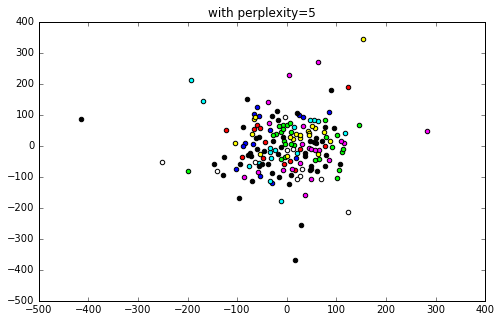

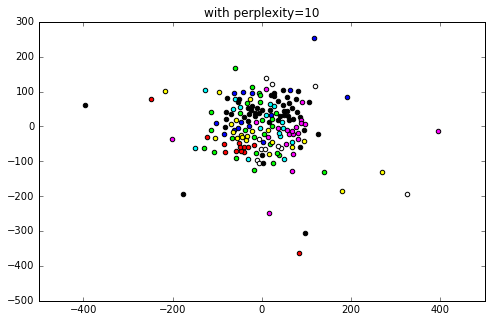

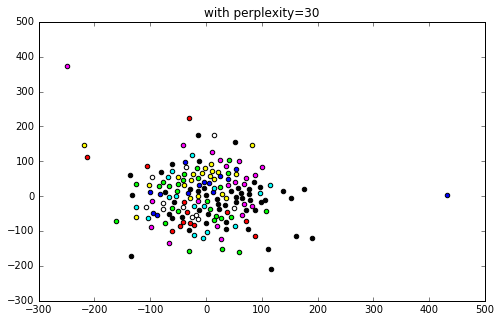

In [20]:
from sklearn.manifold import TSNE

for perplexity in [5, 10, 30]:    
    tsne_full = TSNE(n_components=2, perplexity=perplexity)
    z_full = tsne_full.fit_transform(x)

    plt.figure(figsize=(8,5))
    for lk in set(label):
        row_idx = [i for i, li in enumerate(label) if li == lk]
        z_k = z_full[row_idx]
        color = get_color(lk)
        plt.scatter(z_k[:,0], z_k[:,1], c=color)
    plt.title('with perplexity={}'.format(perplexity))
    plt.show()

차라리 군집화를 했으니, 그 군집의 centroids 주변에 해당 군집에 속하는 영화를 플랏팅 하는게 더 좋을 것 같습니다. 

위처럼 document vectors를 그대로 임베딩 한 뒤, 군집화 결과로 색을 칠해봤자, 군집화의 결과를 시각적으로 설명할 수 없습니다. 아래는 10개 군집의 centroids와 그 군집의 영화를 임의로 2개를 추출해서 label을 달아둔 것입니다.

clustervis.scatterplot은 문서 군집화의 결과인 c (centroids vector)를 먼저 임베딩 한 뒤, voronoi diagram 범위 안에서 데이터와 군집 중심간의 거리에 비례하게 데이터 포인트를 플랏팅 한 것입니다. 

scatterplot의 return 값들의 의미는 아래와 같습니다. 

    z_x: 데이터 포인트의 2 차원 임베딩 벡터
    z_c: 군집의 centroids의 2 차원 임베딩 벡터
    zrmax: 각 군집의 2차원에서의 최대 영역 radius

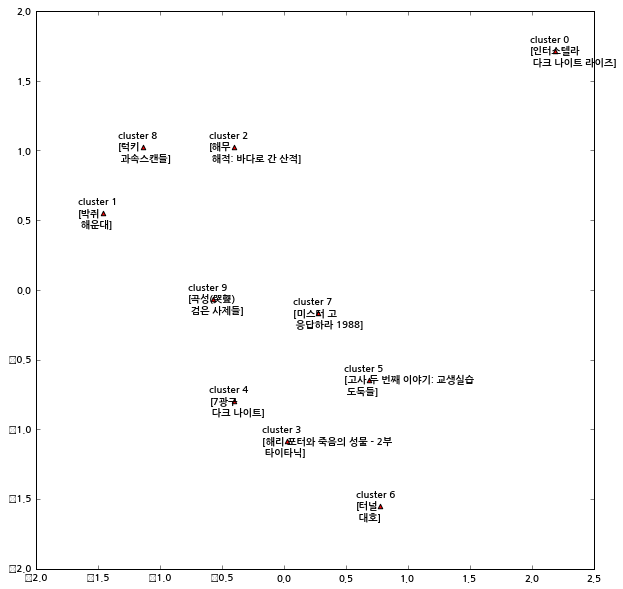

In [36]:
from clustervis import scatterplot
# z_x, z_c, zrmax = scatterplot(x, c, label, square=True)

plt.figure(figsize=(10,10))
for k, z_ck in enumerate(z_c):
    x, y = (z_ck[0], z_ck[1])
    plt.scatter(x, y, marker='^', c='red')
    samples = [xlabel[i] for i, ci in enumerate(label) if ci == k][:2]
    plt.annotate('cluster {} \n[{}\n {}]'.format(k, samples[0], samples[1]), (x-0.2, y-0.1))
plt.show()

이 centroids 주변에 해당 군집에 속하는 문서들을 voronoi diagram을 넘지 않는 영역 안에 plotting을 합니다. 

분홍색의 원은 군집의 centroids 로부터 가장 멀리 있는 점까지의 거리를 radius로 하는, 각 군집의 범위입니다. 애초에 t-SNE가 임베딩이 잘 되지 않기 때문에 t-SNE의 학습 결과를 잘 보존하는 것보다, **데이터들이 군집화의 결과를 잘 반영할 수 있도록 시각화** 하는 것에 집중하는 것이 더 설명력이 있습니다. 

Annotation의 위치는 손쉽게 잡기가 어렵네요. 이거는 dx, dy로 대충 움직여서 찍었습니다. 

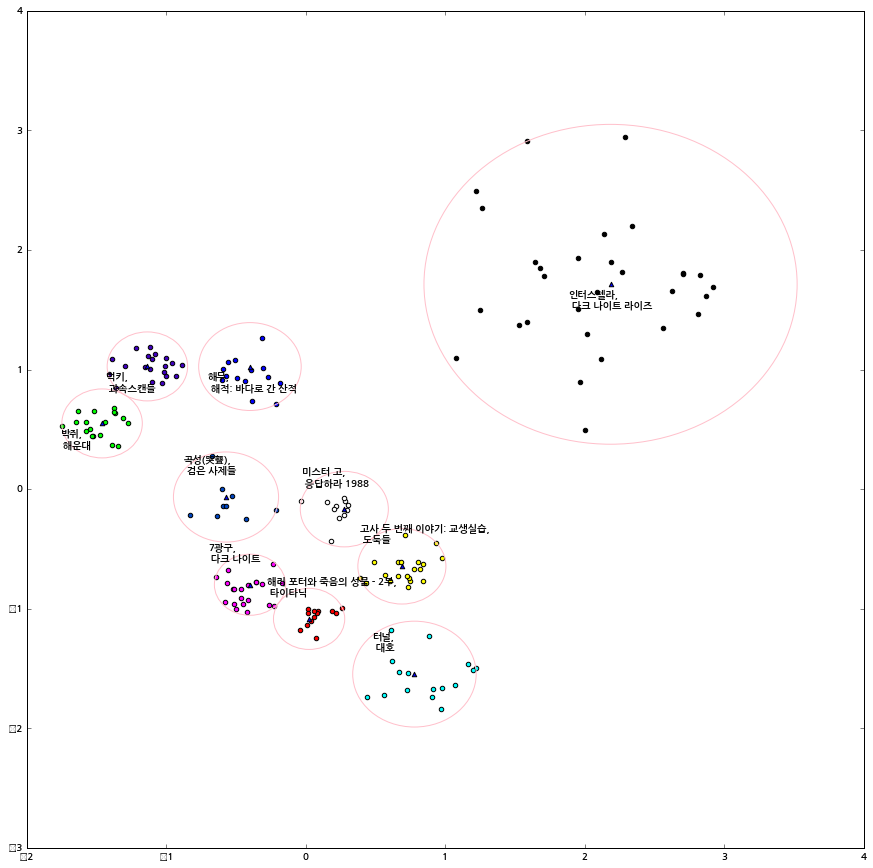

In [38]:
plt.figure(figsize=(15,15))
for lk in set(label):
    row_idx = [i for i, li in enumerate(label) if li == lk]
    z_k = z_x[row_idx]
    color = get_color(lk)
    plt.scatter(z_k[:,0], z_k[:,1], c=color)
    
for k, z_ck in enumerate(z_c):
    x, y = (z_ck[0], z_ck[1])
    plt.scatter(x, y, marker='^', c='b')
    circle = plt.Circle((x, y), zrmax[k], color='pink', fill=False)
    samples = [xlabel[i] for i, ci in enumerate(label) if ci == k][:2]
    
    dx = 0.3
    dy = 0.2 if y > 0 else -0.2
    plt.annotate('{},\n {}'.format(samples[0], samples[1]), (x-dx, y-dy))
    plt.gcf().gca().add_artist(circle)

plt.show()